In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification,DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_recall_curve, auc
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
import os

In [2]:
data = pd.read_csv("dataset/Kaggle.csv")
model_dir ='models/BERT/Kaggle/'

# KAGGLE

In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
os.makedirs(model_dir, exist_ok=True)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Load and prepare the dataset
data = pd.read_csv("dataset/Kaggle.csv")  # Replace with your actual file path
print("Dataset head:\n", data.head())

# Extract relevant columns
tweets = data["tweet"].tolist()
labels = data["class"].tolist()  # 0: hate speech, 1: offensive language, 2: neither

# Check class distribution
print(f"Total samples: {len(tweets)}")
print(f"Hate speech (0): {sum(1 for l in labels if l == 0)}")
print(f"Offensive language (1): {sum(1 for l in labels if l == 1)}")
print(f"Neither (2): {sum(1 for l in labels if l == 2)}")

# Split into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(tweets, labels, test_size=0.3, stratify=labels, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


Dataset head:
    Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
Total samples: 24783
Hate speech (0): 1430
Offensive language (1): 19190
Neither (2): 4163


In [5]:
class TweetDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_length=128):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(tweet, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


In [6]:

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Move to device
model.to(device)

# Prepare datasets
train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:


# Zero-shot mechanism: Define hypotheses for each class
hypotheses = [
    "This text contains hate speech targeting a group or individual.",
    "This text contains offensive language but not hate speech.",
    "This text is neither hate speech nor offensive."
]

# Function to classify an input sentence using zero-shot
def classify_sentence(sentence,model):
    model.eval()
    inputs = tokenizer([f"{sentence} [SEP] {hyp}" for hyp in hypotheses], 
                      padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs).logits
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]  # Probabilities for each hypothesis
    
    print(f"\nInput sentence: '{sentence}'")
    print("Applicability to each category:")
    print(f"Hate Speech (0): {probs[0]:.4f}")
    print(f"Offensive Language (1): {probs[1]:.4f}")
    print(f"Neither (2): {probs[2]:.4f}")
    
    # Determine predicted class
    predicted_class = np.argmax(probs)
    class_names = ["Hate Speech", "Offensive Language", "Neither"]
    print(f"Predicted class: {class_names[predicted_class]} ({predicted_class})")


In [8]:
# Testing mechanism
def test_model(model,path):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total = 0
    correct = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask).logits
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
            correct += (preds == labels.cpu().numpy()).sum()
            total += labels.size(0)
    
    # Calculate metrics
    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=[0, 1, 2])
    cm = confusion_matrix(all_labels, all_preds)
    
    # Print metrics
    class_names = ["Hate Speech", "Offensive Language", "Neither"]
    print(f"\nTest Accuracy: {accuracy:.4f}")
    for i, name in enumerate(class_names):
        print(f"\n{name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")

    # Fancy Confusion Matrix Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Count'},
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 14, "weight": "bold"})
    plt.title("Confusion Matrix\n(Toxic Content Classification)", fontsize=16, pad=20, weight="bold")
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

    # Fancy Precision-Recall Curve
    plt.figure(figsize=(10, 8))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Custom colors for each class
    for i, (name, color) in enumerate(zip(class_names, colors)):
        precision_curve, recall_curve, _ = precision_recall_curve(
            [1 if l == i else 0 for l in all_labels], 
            [p[i] for p in all_probs]
        )
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f"{name} (AUC = {pr_auc:.2f})", 
                 color=color, lw=2.5, linestyle='-' if i % 2 == 0 else '--')
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curve\n(Toxic Content Classification)", fontsize=16, pad=20, weight="bold")
    plt.legend(loc="lower left", fontsize=12, frameon=True, shadow=True, facecolor="white")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.fill_between([0, 1], [1, 0], alpha=0.1, color="gray")
    plt.tight_layout()
    plt.savefig(path)  # Save plot

    plt.show()

Testing: 100%|████████████████████████████████| 117/117 [00:08<00:00, 13.73it/s]


Test Accuracy: 0.6821

Hate Speech:
  Precision: 0.0607
  Recall: 0.1262
  F1-Score: 0.0819

Offensive Language:
  Precision: 0.7679
  Recall: 0.8711
  F1-Score: 0.8163

Neither:
  Precision: 0.1429
  Recall: 0.0016
  F1-Score: 0.0032


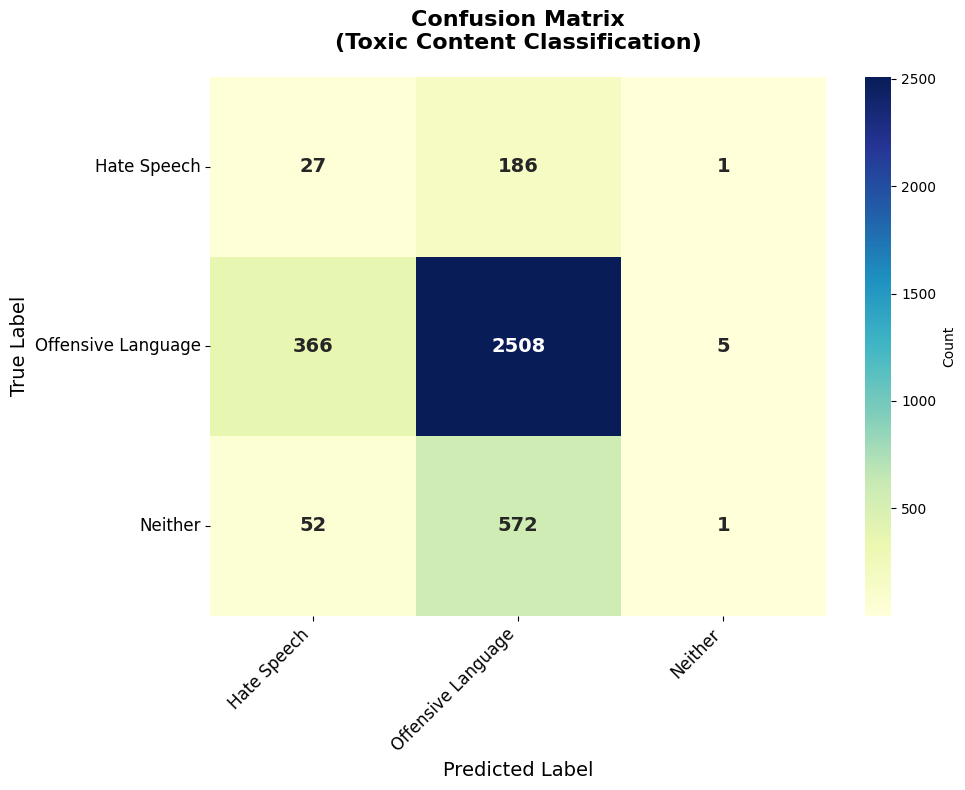

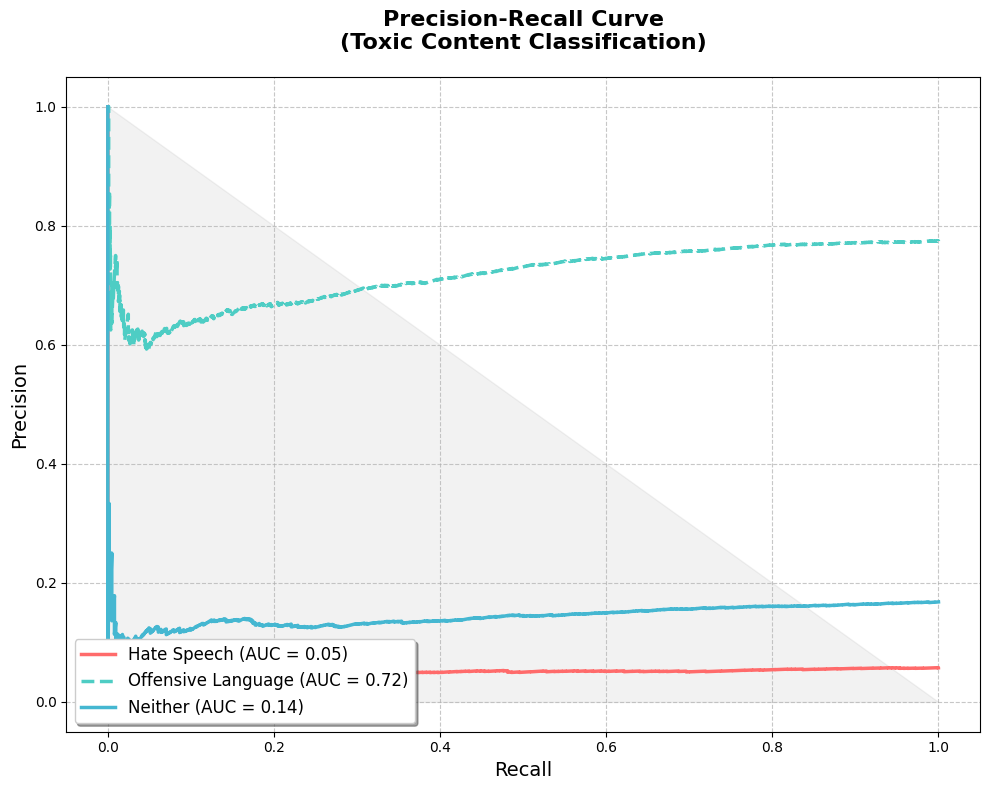

In [10]:
# Run testing
test_model(model,os.path.join(model_dir, "training_metrics_sentiment_PFT.png"))

In [9]:
def interactive_classification(model):
    while True:
        sentence = input("\nEnter a sentence to classify (or 'exit' to stop): ")
        if sentence.lower() == "exit":
            break
        classify_sentence(sentence,model)

In [13]:
# Run evaluation and interactive classification
interactive_classification(model)


Enter a sentence to classify (or 'exit' to stop):  You are good



Input sentence: 'You are good'
Applicability to each category:
Hate Speech (0): 0.3020
Offensive Language (1): 0.4419
Neither (2): 0.2561
Predicted class: Offensive Language (1)



Enter a sentence to classify (or 'exit' to stop):  I hate you



Input sentence: 'I hate you'
Applicability to each category:
Hate Speech (0): 0.2896
Offensive Language (1): 0.4629
Neither (2): 0.2475
Predicted class: Offensive Language (1)



Enter a sentence to classify (or 'exit' to stop):  I fucking hate you



Input sentence: 'I fucking hate you'
Applicability to each category:
Hate Speech (0): 0.2888
Offensive Language (1): 0.4666
Neither (2): 0.2446
Predicted class: Offensive Language (1)



Enter a sentence to classify (or 'exit' to stop):  I fucking hate you and want to kill you



Input sentence: 'I fucking hate you and want to kill you'
Applicability to each category:
Hate Speech (0): 0.2861
Offensive Language (1): 0.4682
Neither (2): 0.2458
Predicted class: Offensive Language (1)



Enter a sentence to classify (or 'exit' to stop):  exit


Epoch 1/15: 100%|███████████| 543/543 [01:54<00:00,  4.74it/s, train_loss=0.327]


Epoch 1 - Train Loss: 0.3273, Val Loss: 0.2332, Val Accuracy: 0.9147


Epoch 2/15: 100%|███████████| 543/543 [01:54<00:00,  4.75it/s, train_loss=0.222]


Epoch 2 - Train Loss: 0.2219, Val Loss: 0.2258, Val Accuracy: 0.9158


Epoch 3/15: 100%|███████████| 543/543 [01:54<00:00,  4.74it/s, train_loss=0.175]


Epoch 3 - Train Loss: 0.1753, Val Loss: 0.2441, Val Accuracy: 0.9177


Epoch 4/15: 100%|███████████| 543/543 [01:54<00:00,  4.74it/s, train_loss=0.124]


Epoch 4 - Train Loss: 0.1242, Val Loss: 0.2785, Val Accuracy: 0.9139


Epoch 5/15: 100%|██████████| 543/543 [01:54<00:00,  4.73it/s, train_loss=0.0838]


Epoch 5 - Train Loss: 0.0838, Val Loss: 0.3172, Val Accuracy: 0.9058


Epoch 6/15: 100%|██████████| 543/543 [01:54<00:00,  4.73it/s, train_loss=0.0487]


Epoch 6 - Train Loss: 0.0487, Val Loss: 0.3690, Val Accuracy: 0.9010


Epoch 7/15: 100%|██████████| 543/543 [01:54<00:00,  4.73it/s, train_loss=0.0307]


Epoch 7 - Train Loss: 0.0307, Val Loss: 0.3721, Val Accuracy: 0.9136
Early stopping triggered after 7 epochs


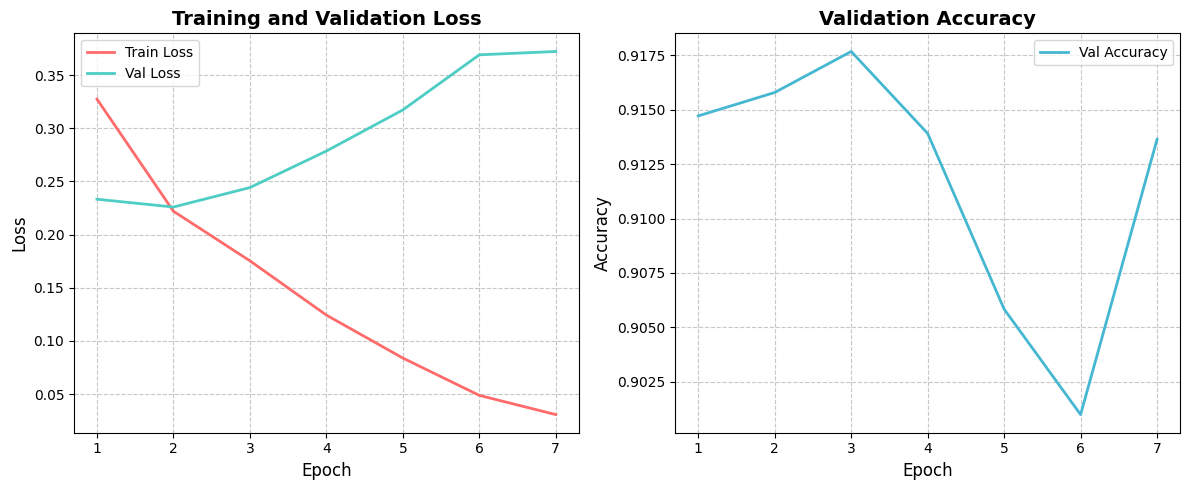

In [10]:
from tqdm import tqdm

# Fine-tune with tqdm and validation
def fine_tune_model(model_path,max_epochs=5, patience=2):
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(max_epochs):
        # Training
        model.train()
        total_train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", leave=True)
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            loop.set_postfix(train_loss=total_train_loss / (loop.n + 1))
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                total_val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color="#FF6B6B", lw=2)
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss", color="#4ECDC4", lw=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training and Validation Loss", fontsize=14, weight="bold")
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy", color="#45B7D1", lw=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Validation Accuracy", fontsize=14, weight="bold")
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

    return   # Return number of epochs run
    
model_path = os.path.join(model_dir, "bestBert.pth")

fine_tune_model(model_path,max_epochs=15, patience=5)

Testing: 100%|████████████████████████████████| 117/117 [00:08<00:00, 13.92it/s]



Test Accuracy: 0.9155

Hate Speech:
  Precision: 0.5652
  Recall: 0.1215
  F1-Score: 0.2000

Offensive Language:
  Precision: 0.9361
  Recall: 0.9673
  F1-Score: 0.9515

Neither:
  Precision: 0.8508
  Recall: 0.9488
  F1-Score: 0.8971


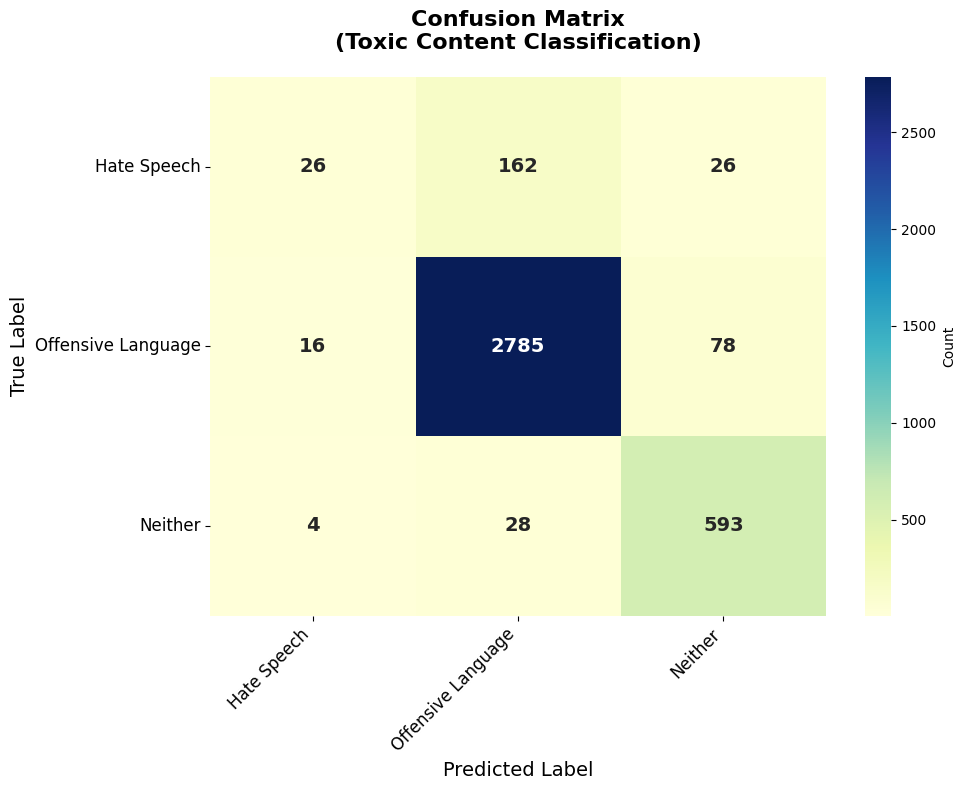

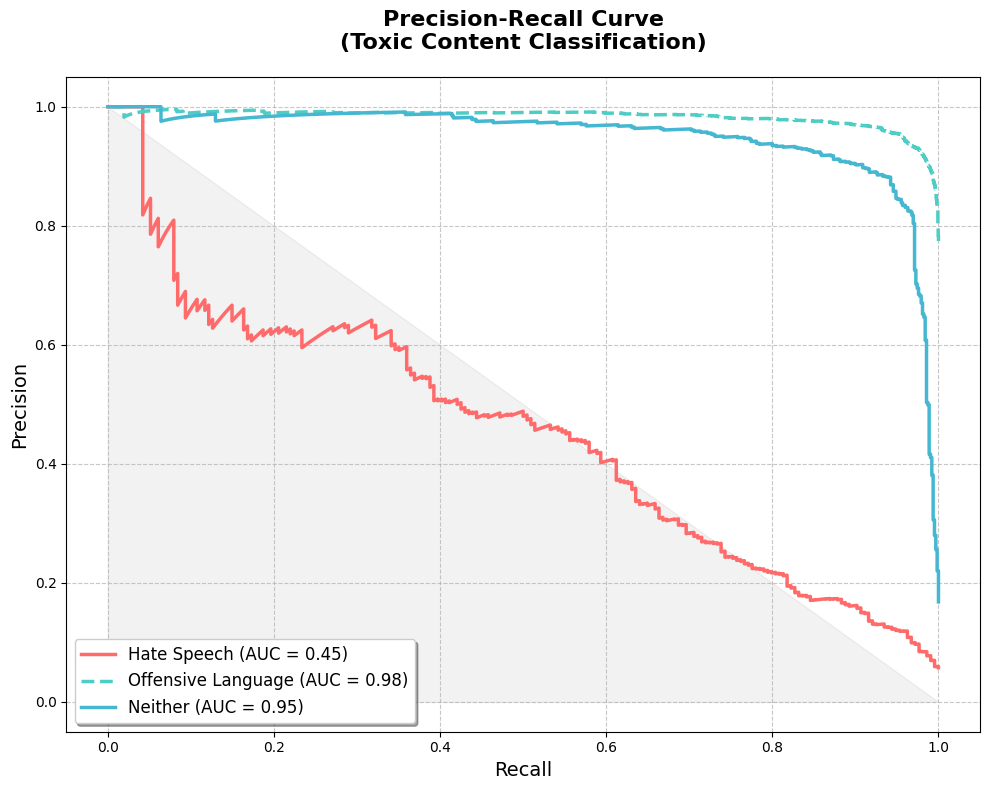


Enter a sentence to classify (or 'exit' to stop):  You are good



Input sentence: 'You are good'
Applicability to each category:
Hate Speech (0): 0.2080
Offensive Language (1): 0.1361
Neither (2): 0.6559
Predicted class: Neither (2)



Enter a sentence to classify (or 'exit' to stop):  I hate you



Input sentence: 'I hate you'
Applicability to each category:
Hate Speech (0): 0.3538
Offensive Language (1): 0.2009
Neither (2): 0.4453
Predicted class: Neither (2)



Enter a sentence to classify (or 'exit' to stop):  I fucking hate you



Input sentence: 'I fucking hate you'
Applicability to each category:
Hate Speech (0): 0.1598
Offensive Language (1): 0.8356
Neither (2): 0.0046
Predicted class: Offensive Language (1)



Enter a sentence to classify (or 'exit' to stop):  I fucking hate you and want to kill you



Input sentence: 'I fucking hate you and want to kill you'
Applicability to each category:
Hate Speech (0): 0.2069
Offensive Language (1): 0.7876
Neither (2): 0.0056
Predicted class: Offensive Language (1)



Enter a sentence to classify (or 'exit' to stop):  exit


In [11]:
model.load_state_dict(torch.load(model_path))
model.eval()
# Run evaluation and interactive classification
test_model(model,os.path.join(model_dir, "training_metrics_sentiment_PostFT.png"))
interactive_classification(model)

In [12]:
# Function to count trainable parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to compute FLOPs (simplified)
def compute_flops(model):
    return count_params(model) * 2  # Rough estimate
compute_flops(model)

218969094

# UCB

In [3]:

data = pd.read_csv("dataset/RawUCB.csv")
model_dir ='models/BERT/UCB/'
os.makedirs(model_dir, exist_ok=True)
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)  
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)


NameError: name 'os' is not defined

In [ ]:
data

In [3]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = [int(label) for label in labels]  # Convert float scores (0.0 to 4.0) to integers (0 to 4)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)  # 5-class labels
        }

In [11]:
# Testing mechanism
def test_model_UCB(model,path):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total = 0
    correct = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask).logits
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
            correct += (preds == labels.cpu().numpy()).sum()
            total += labels.size(0)
    
    # Calculate metrics
    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=[0, 1, 2,3,4])
    cm = confusion_matrix(all_labels, all_preds)
    
    # Print metrics
    class_names = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
    print(f"\nTest Accuracy: {accuracy:.4f}")
    for i, name in enumerate(class_names):
        print(f"\n{name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")

    # Fancy Confusion Matrix Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Count'},
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 14, "weight": "bold"})
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']

    for i, (name, color) in enumerate(zip(class_names, colors)):
        precision_curve, recall_curve, _ = precision_recall_curve(
            [1 if l == i else 0 for l in all_labels], 
            [p[i] for p in all_probs]
        )
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f"{name} (AUC = {pr_auc:.2f})", 
                 color=color, lw=2.5, linestyle='-' if i % 2 == 0 else '--')
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curve\n(Toxic Content Classification)", fontsize=16, pad=20, weight="bold")
    plt.legend(loc="lower left", fontsize=12, frameon=True, shadow=True, facecolor="white")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.fill_between([0, 1], [1, 0], alpha=0.1, color="gray")
    plt.tight_layout()
    plt.savefig(path)  # Save plot

    plt.show()

Total samples: 135556
Toxic: 120025
Non-toxic: 15531

Sentiment distribution: {0.0: 9658, 1.0: 9435, 2.0: 19785, 3.0: 35243, 4.0: 61435}
Respect distribution: {0.0: 12839, 1.0: 9629, 2.0: 23895, 3.0: 30720, 4.0: 58473}
Insult distribution: {0.0: 18476, 1.0: 14667, 2.0: 18587, 3.0: 39673, 4.0: 44153}
Humiliate distribution: {0.0: 21306, 1.0: 19555, 2.0: 25035, 3.0: 39382, 4.0: 30278}
Status distribution: {0.0: 1228, 1.0: 4261, 2.0: 61154, 3.0: 36413, 4.0: 32500}
Dehumanize distribution: {0.0: 31855, 1.0: 28434, 2.0: 25292, 3.0: 28653, 4.0: 21322}
Violence distribution: {0.0: 67922, 1.0: 30727, 2.0: 12241, 3.0: 11262, 4.0: 13404}


Testing: 100%|████████████████████████████████| 636/636 [00:42<00:00, 14.81it/s]
/home/mabon/anaconda3/envs/torch2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Accuracy: 0.1937

Very Negative:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

Negative:
  Precision: 0.0687
  Recall: 0.3307
  F1-Score: 0.1138

Neutral:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

Positive:
  Precision: 0.2559
  Recall: 0.6434
  F1-Score: 0.3661

Very Positive:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000


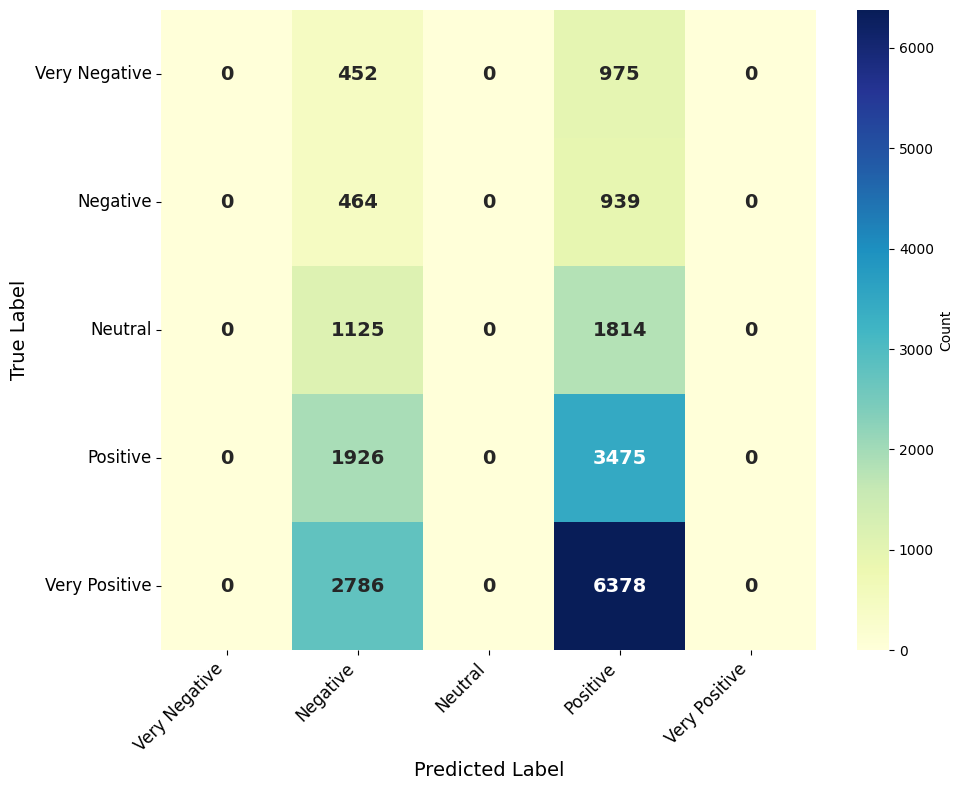

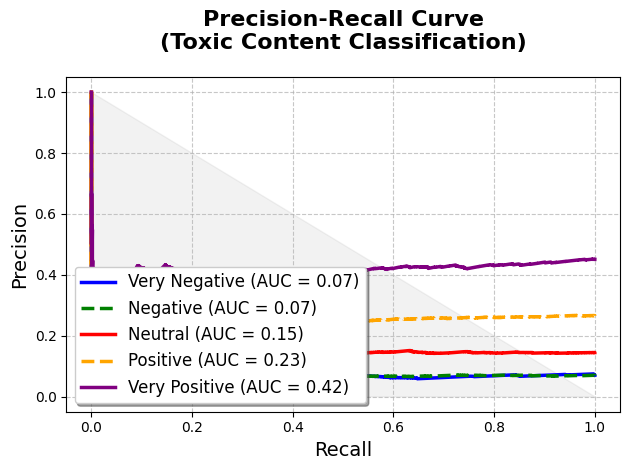

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load and prepare the dataset

# Extract relevant columns
comments = data["sentence"].tolist()
labels = data["label"].tolist()  # 'toxic' or 'non-toxic'
sentiment = data["sentiment"].tolist()  # Numerical (0.0 to 4.0)
respect = data["respect"].tolist()  # Numerical (0.0 to 4.0)
insult = data["insult"].tolist()  # Numerical (0.0 to 4.0)
humiliate = data["humiliate"].tolist()  # Numerical (0.0 to 4.0)
status = data["status"].tolist()  # Numerical (0.0 to 4.0)
dehumanize = data["dehumanize"].tolist()  # Numerical (0.0 to 4.0)
violence = data["violence"].tolist()  # Numerical (0.0 to 4.0)

# Check class distribution for binary label
print(f"Total samples: {len(comments)}")
print(f"Toxic: {sum(1 for l in labels if l == 'toxic')}")
print(f"Non-toxic: {sum(1 for l in labels if l == 'non-toxic')}")

# Check distribution for numerical attributes, filtering out None values
print("\nSentiment distribution:", {x: sentiment.count(x) for x in sorted(x for x in set(sentiment) if x is not None)})
print("Respect distribution:", {x: respect.count(x) for x in sorted(x for x in set(respect) if x is not None)})
print("Insult distribution:", {x: insult.count(x) for x in sorted(x for x in set(insult) if x is not None)})
print("Humiliate distribution:", {x: humiliate.count(x) for x in sorted(x for x in set(humiliate) if x is not None)})
print("Status distribution:", {x: status.count(x) for x in sorted(x for x in set(status) if x is not None)})
print("Dehumanize distribution:", {x: dehumanize.count(x) for x in sorted(x for x in set(dehumanize) if x is not None)})
print("Violence distribution:", {x: violence.count(x) for x in sorted(x for x in set(violence) if x is not None)})

# Split into train, validation, and test sets (stratified by binary label)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    comments, labels, test_size=0.3, stratify=labels, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Split numerical attributes using the same indices
train_idx, temp_idx = train_test_split(range(len(comments)), test_size=0.3, stratify=labels, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=temp_labels, random_state=42)

train_sentiment = [sentiment[i] for i in train_idx]
val_sentiment = [sentiment[i] for i in val_idx]
test_sentiment = [sentiment[i] for i in test_idx]

train_respect = [respect[i] for i in train_idx]
val_respect = [respect[i] for i in val_idx]
test_respect = [respect[i] for i in test_idx]

train_insult = [insult[i] for i in train_idx]
val_insult = [insult[i] for i in val_idx]
test_insult = [insult[i] for i in test_idx]

train_humiliate = [humiliate[i] for i in train_idx]
val_humiliate = [humiliate[i] for i in val_idx]
test_humiliate = [humiliate[i] for i in test_idx]

train_status = [status[i] for i in train_idx]
val_status = [status[i] for i in val_idx]
test_status = [status[i] for i in test_idx]

train_dehumanize = [dehumanize[i] for i in train_idx]
val_dehumanize = [dehumanize[i] for i in val_idx]
test_dehumanize = [dehumanize[i] for i in test_idx]

train_violence = [violence[i] for i in train_idx]
val_violence = [violence[i] for i in val_idx]
test_violence = [violence[i] for i in test_idx]

train_dataset = TweetDataset(train_texts, train_sentiment, tokenizer)
val_dataset = TweetDataset(val_texts, val_sentiment, tokenizer)
test_dataset = TweetDataset(test_texts, test_sentiment, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Move to device
model.to(device)

test_model_UCB(model,os.path.join(model_dir, "training_metrics_sentiment_PFT.png"))

In [13]:


# Zero-shot mechanism: Define hypotheses for each attribute (excluding label)
hypotheses = {
    "sentiment": [
        "This text expresses no sentiment (neutral, score 0).",
        "This text expresses slightly positive or negative sentiment (score 1).",
        "This text expresses moderate positive or negative sentiment (score 2).",
        "This text expresses strong positive or negative sentiment (score 3).",
        "This text expresses very strong positive or negative sentiment (score 4)."
    ],
    "respect": [
        "This text shows no respect for others (score 0).",
        "This text shows slight respect for others (score 1).",
        "This text shows moderate respect for others (score 2).",
        "This text shows strong respect for others (score 3).",
        "This text shows very strong respect for others (score 4)."
    ],
    "insult": [
        "This text contains no insults (score 0).",
        "This text contains mild insults (score 1).",
        "This text contains moderate insults (score 2).",
        "This text contains strong insults (score 3).",
        "This text contains very strong insults (score 4)."
    ],
    "humiliate": [
        "This text does not humiliate anyone (score 0).",
        "This text slightly humiliates someone (score 1).",
        "This text moderately humiliates someone (score 2).",
        "This text strongly humiliates someone (score 3).",
        "This text very strongly humiliates someone (score 4)."
    ],
    "status": [
        "This text does not reference social status (score 0).",
        "This text slightly references social status (score 1).",
        "This text moderately references social status (score 2).",
        "This text strongly references social status (score 3).",
        "This text very strongly references social status (score 4)."
    ],
    "dehumanize": [
        "This text does not dehumanize anyone (score 0).",
        "This text slightly dehumanizes someone (score 1).",
        "This text moderately dehumanizes someone (score 2).",
        "This text strongly dehumanizes someone (score 3).",
        "This text very strongly dehumanizes someone (score 4)."
    ],
    "violence": [
        "This text contains no references to violence (score 0).",
        "This text contains slight references to violence (score 1).",
        "This text contains moderate references to violence (score 2).",
        "This text contains strong references to violence (score 3).",
        "This text contains very strong references to violence (score 4)."
    ]
}

# Function to classify an input sentence using zero-shot for all attributes
def classify_sentence(sentence, model):
    model.eval()
    for attribute, hyp_list in hypotheses.items():
        print(f"\nClassifying for {attribute.upper()}:")
        inputs = tokenizer([f"{sentence} [SEP] {hyp}" for hyp in hyp_list], 
                          padding=True, truncation=True, max_length=128, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs).logits
            probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]  # Probabilities for 5 classes
        
        print(f"Input sentence: '{sentence}'")
        print("Applicability to each category:")
        class_names = [f"Score {i} ({i})" for i in range(len(hyp_list))]
        for i, (prob, hyp) in enumerate(zip(probs, hyp_list)):
            print(f"{class_names[i]}: {prob:.4f} - {hyp}")
        predicted_class = np.argmax(probs)
        print(f"Predicted class: {class_names[predicted_class]} - {hyp_list[predicted_class]}")

In [14]:
def interactive_classification(model):
    while True:
        sentence = input("\nEnter a sentence to classify (or 'exit' to stop): ")
        if sentence.lower() == "exit":
            break
        classify_sentence(sentence,model)
interactive_classification(model)


Enter a sentence to classify (or 'exit' to stop):  You are good



Classifying for SENTIMENT:
Input sentence: 'You are good'
Applicability to each category:
Score 0 (0): 0.1612 - This text expresses no sentiment (neutral, score 0).
Score 1 (1): 0.1989 - This text expresses slightly positive or negative sentiment (score 1).
Score 2 (2): 0.1845 - This text expresses moderate positive or negative sentiment (score 2).
Score 3 (3): 0.2657 - This text expresses strong positive or negative sentiment (score 3).
Score 4 (4): 0.1897 - This text expresses very strong positive or negative sentiment (score 4).
Predicted class: Score 3 (3) - This text expresses strong positive or negative sentiment (score 3).

Classifying for RESPECT:
Input sentence: 'You are good'
Applicability to each category:
Score 0 (0): 0.1634 - This text shows no respect for others (score 0).
Score 1 (1): 0.2168 - This text shows slight respect for others (score 1).
Score 2 (2): 0.1901 - This text shows moderate respect for others (score 2).
Score 3 (3): 0.2469 - This text shows strong resp


Enter a sentence to classify (or 'exit' to stop):  I hate you



Classifying for SENTIMENT:
Input sentence: 'I hate you'
Applicability to each category:
Score 0 (0): 0.1487 - This text expresses no sentiment (neutral, score 0).
Score 1 (1): 0.1753 - This text expresses slightly positive or negative sentiment (score 1).
Score 2 (2): 0.1773 - This text expresses moderate positive or negative sentiment (score 2).
Score 3 (3): 0.3013 - This text expresses strong positive or negative sentiment (score 3).
Score 4 (4): 0.1974 - This text expresses very strong positive or negative sentiment (score 4).
Predicted class: Score 3 (3) - This text expresses strong positive or negative sentiment (score 3).

Classifying for RESPECT:
Input sentence: 'I hate you'
Applicability to each category:
Score 0 (0): 0.1524 - This text shows no respect for others (score 0).
Score 1 (1): 0.2052 - This text shows slight respect for others (score 1).
Score 2 (2): 0.1843 - This text shows moderate respect for others (score 2).
Score 3 (3): 0.2739 - This text shows strong respect 


Enter a sentence to classify (or 'exit' to stop):  I fucking hate you



Classifying for SENTIMENT:
Input sentence: 'I fucking hate you'
Applicability to each category:
Score 0 (0): 0.1495 - This text expresses no sentiment (neutral, score 0).
Score 1 (1): 0.1911 - This text expresses slightly positive or negative sentiment (score 1).
Score 2 (2): 0.1734 - This text expresses moderate positive or negative sentiment (score 2).
Score 3 (3): 0.2905 - This text expresses strong positive or negative sentiment (score 3).
Score 4 (4): 0.1954 - This text expresses very strong positive or negative sentiment (score 4).
Predicted class: Score 3 (3) - This text expresses strong positive or negative sentiment (score 3).

Classifying for RESPECT:
Input sentence: 'I fucking hate you'
Applicability to each category:
Score 0 (0): 0.1555 - This text shows no respect for others (score 0).
Score 1 (1): 0.2213 - This text shows slight respect for others (score 1).
Score 2 (2): 0.1827 - This text shows moderate respect for others (score 2).
Score 3 (3): 0.2572 - This text shows


Enter a sentence to classify (or 'exit' to stop):  I fucking hate you and want to kill you



Classifying for SENTIMENT:
Input sentence: 'I fucking hate you and want to kill you'
Applicability to each category:
Score 0 (0): 0.1504 - This text expresses no sentiment (neutral, score 0).
Score 1 (1): 0.1986 - This text expresses slightly positive or negative sentiment (score 1).
Score 2 (2): 0.1745 - This text expresses moderate positive or negative sentiment (score 2).
Score 3 (3): 0.2811 - This text expresses strong positive or negative sentiment (score 3).
Score 4 (4): 0.1953 - This text expresses very strong positive or negative sentiment (score 4).
Predicted class: Score 3 (3) - This text expresses strong positive or negative sentiment (score 3).

Classifying for RESPECT:
Input sentence: 'I fucking hate you and want to kill you'
Applicability to each category:
Score 0 (0): 0.1563 - This text shows no respect for others (score 0).
Score 1 (1): 0.2215 - This text shows slight respect for others (score 1).
Score 2 (2): 0.1854 - This text shows moderate respect for others (score


Enter a sentence to classify (or 'exit' to stop):  exit


In [15]:
from torch.optim.lr_scheduler import StepLR

# Fine-tune with tqdm and validation, including learning rate scheduler
def fine_tune_model(model, train_loader, val_loader, model_path, model_dir, max_epochs=5, patience=2):
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.1)  # StepLR scheduler: decrease lr by factor of 0.1 every 2 epochs
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(max_epochs):
        # Training
        model.train()
        total_train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", leave=True)
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            loop.set_postfix(train_loss=total_train_loss / (loop.n + 1))

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                total_val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        # Step the scheduler
        scheduler.step()

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color="#FF6B6B", lw=2)
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss", color="#4ECDC4", lw=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training and Validation Loss", fontsize=14, weight="bold")
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy", color="#45B7D1", lw=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Validation Accuracy", fontsize=14, weight="bold")
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, "training_metrics_sentiment.png"))  # Save plot

    return len(train_losses)  # Return number of epochs run


Epoch 1/15: 100%|██████████| 2966/2966 [10:12<00:00,  4.84it/s, train_loss=1.15]


Epoch 1 - Train Loss: 1.1497, Val Loss: 1.1308, Val Accuracy: 0.5033


Epoch 2/15: 100%|██████████| 2966/2966 [10:13<00:00,  4.84it/s, train_loss=1.14]


Epoch 2 - Train Loss: 1.1396, Val Loss: 1.1274, Val Accuracy: 0.5047


Epoch 3/15: 100%|██████████| 2966/2966 [10:01<00:00,  4.93it/s, train_loss=1.13]


Epoch 3 - Train Loss: 1.1254, Val Loss: 1.1251, Val Accuracy: 0.5102


Epoch 4/15: 100%|███████████| 2966/2966 [10:06<00:00,  4.89it/s, train_loss=1.1]


Epoch 4 - Train Loss: 1.0994, Val Loss: 1.1088, Val Accuracy: 0.5152


Epoch 5/15: 100%|██████████| 2966/2966 [10:40<00:00,  4.63it/s, train_loss=1.06]


Epoch 5 - Train Loss: 1.0572, Val Loss: 1.0979, Val Accuracy: 0.5206


Epoch 6/15: 100%|██████████| 2966/2966 [10:07<00:00,  4.88it/s, train_loss=1.01]


Epoch 6 - Train Loss: 1.0100, Val Loss: 1.1095, Val Accuracy: 0.5199


Epoch 7/15: 100%|██████████| 2966/2966 [09:55<00:00,  4.98it/s, train_loss=0.96]


Epoch 7 - Train Loss: 0.9595, Val Loss: 1.0988, Val Accuracy: 0.5240


Epoch 8/15: 100%|█████████| 2966/2966 [09:55<00:00,  4.98it/s, train_loss=0.913]


Epoch 8 - Train Loss: 0.9126, Val Loss: 1.1244, Val Accuracy: 0.5386


Epoch 9/15: 100%|█████████| 2966/2966 [09:55<00:00,  4.98it/s, train_loss=0.872]


Epoch 9 - Train Loss: 0.8719, Val Loss: 1.1305, Val Accuracy: 0.5439


Epoch 10/15: 100%|█████████| 2966/2966 [09:55<00:00,  4.98it/s, train_loss=0.83]


Epoch 10 - Train Loss: 0.8303, Val Loss: 1.1704, Val Accuracy: 0.5461
Early stopping triggered after 10 epochs


10

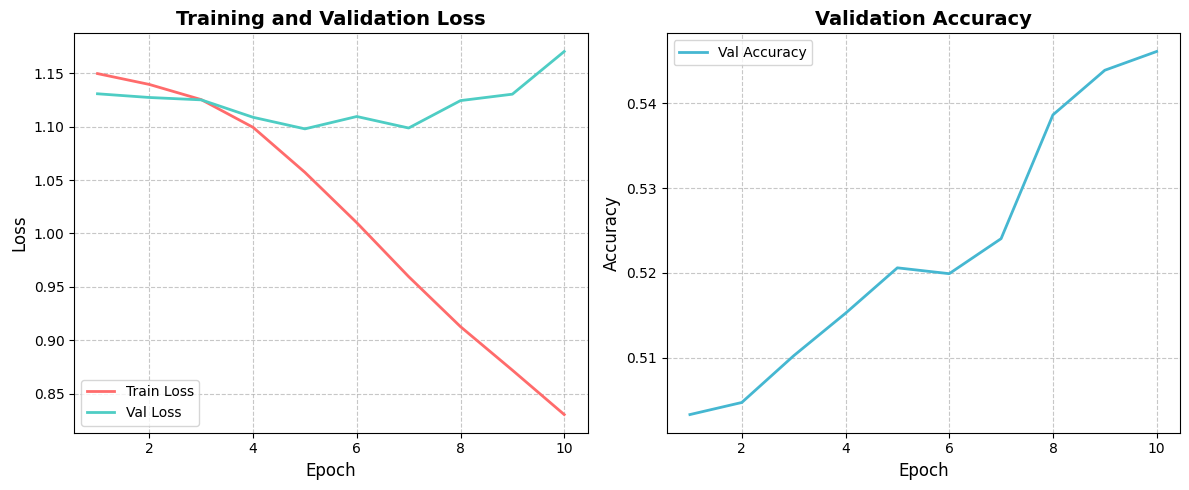

In [17]:
import os
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "bestBert.pth")
# Run fine-tuning
fine_tune_model(model, train_loader, val_loader, model_path, max_epochs=15, patience=5)

In [18]:
model.load_state_dict(torch.load(model_path))
model.eval()
# Run evaluation and interactive classification
interactive_classification(model)


Enter a sentence to classify (or 'exit' to stop):  You are good



Classifying for SENTIMENT:
Input sentence: 'You are good'
Applicability to each category:
Score 0 (0): 0.0602 - This text expresses no sentiment (neutral, score 0).
Score 1 (1): 0.0791 - This text expresses slightly positive or negative sentiment (score 1).
Score 2 (2): 0.1785 - This text expresses moderate positive or negative sentiment (score 2).
Score 3 (3): 0.2897 - This text expresses strong positive or negative sentiment (score 3).
Score 4 (4): 0.3924 - This text expresses very strong positive or negative sentiment (score 4).
Predicted class: Score 4 (4) - This text expresses very strong positive or negative sentiment (score 4).

Classifying for RESPECT:
Input sentence: 'You are good'
Applicability to each category:
Score 0 (0): 0.0555 - This text shows no respect for others (score 0).
Score 1 (1): 0.0817 - This text shows slight respect for others (score 1).
Score 2 (2): 0.1771 - This text shows moderate respect for others (score 2).
Score 3 (3): 0.2956 - This text shows strong


Enter a sentence to classify (or 'exit' to stop):  I hate you



Classifying for SENTIMENT:
Input sentence: 'I hate you'
Applicability to each category:
Score 0 (0): 0.0512 - This text expresses no sentiment (neutral, score 0).
Score 1 (1): 0.0721 - This text expresses slightly positive or negative sentiment (score 1).
Score 2 (2): 0.1745 - This text expresses moderate positive or negative sentiment (score 2).
Score 3 (3): 0.3014 - This text expresses strong positive or negative sentiment (score 3).
Score 4 (4): 0.4008 - This text expresses very strong positive or negative sentiment (score 4).
Predicted class: Score 4 (4) - This text expresses very strong positive or negative sentiment (score 4).

Classifying for RESPECT:
Input sentence: 'I hate you'
Applicability to each category:
Score 0 (0): 0.0489 - This text shows no respect for others (score 0).
Score 1 (1): 0.0801 - This text shows slight respect for others (score 1).
Score 2 (2): 0.1776 - This text shows moderate respect for others (score 2).
Score 3 (3): 0.3110 - This text shows strong res


Enter a sentence to classify (or 'exit' to stop):  I fucking hate you



Classifying for SENTIMENT:
Input sentence: 'I fucking hate you'
Applicability to each category:
Score 0 (0): 0.0401 - This text expresses no sentiment (neutral, score 0).
Score 1 (1): 0.0611 - This text expresses slightly positive or negative sentiment (score 1).
Score 2 (2): 0.1575 - This text expresses moderate positive or negative sentiment (score 2).
Score 3 (3): 0.3071 - This text expresses strong positive or negative sentiment (score 3).
Score 4 (4): 0.4341 - This text expresses very strong positive or negative sentiment (score 4).
Predicted class: Score 4 (4) - This text expresses very strong positive or negative sentiment (score 4).

Classifying for RESPECT:
Input sentence: 'I fucking hate you'
Applicability to each category:
Score 0 (0): 0.0408 - This text shows no respect for others (score 0).
Score 1 (1): 0.0715 - This text shows slight respect for others (score 1).
Score 2 (2): 0.1646 - This text shows moderate respect for others (score 2).
Score 3 (3): 0.3147 - This text 


Enter a sentence to classify (or 'exit' to stop):  I fucking hate you and want to kill you



Classifying for SENTIMENT:
Input sentence: 'I fucking hate you and want to kill you'
Applicability to each category:
Score 0 (0): 0.0437 - This text expresses no sentiment (neutral, score 0).
Score 1 (1): 0.0634 - This text expresses slightly positive or negative sentiment (score 1).
Score 2 (2): 0.1666 - This text expresses moderate positive or negative sentiment (score 2).
Score 3 (3): 0.2998 - This text expresses strong positive or negative sentiment (score 3).
Score 4 (4): 0.4264 - This text expresses very strong positive or negative sentiment (score 4).
Predicted class: Score 4 (4) - This text expresses very strong positive or negative sentiment (score 4).

Classifying for RESPECT:
Input sentence: 'I fucking hate you and want to kill you'
Applicability to each category:
Score 0 (0): 0.0429 - This text shows no respect for others (score 0).
Score 1 (1): 0.0718 - This text shows slight respect for others (score 1).
Score 2 (2): 0.1679 - This text shows moderate respect for others (


Enter a sentence to classify (or 'exit' to stop):  exit


Testing: 100%|████████████████████████████████| 636/636 [00:56<00:00, 11.23it/s]



Test Accuracy: 0.5186

Very Negative:
  Precision: 0.4435
  Recall: 0.5473
  F1-Score: 0.4900

Negative:
  Precision: 0.2606
  Recall: 0.0527
  F1-Score: 0.0877

Neutral:
  Precision: 0.3615
  Recall: 0.1732
  F1-Score: 0.2342

Positive:
  Precision: 0.4006
  Recall: 0.3144
  F1-Score: 0.3523

Very Positive:
  Precision: 0.5919
  Recall: 0.8166
  F1-Score: 0.6863


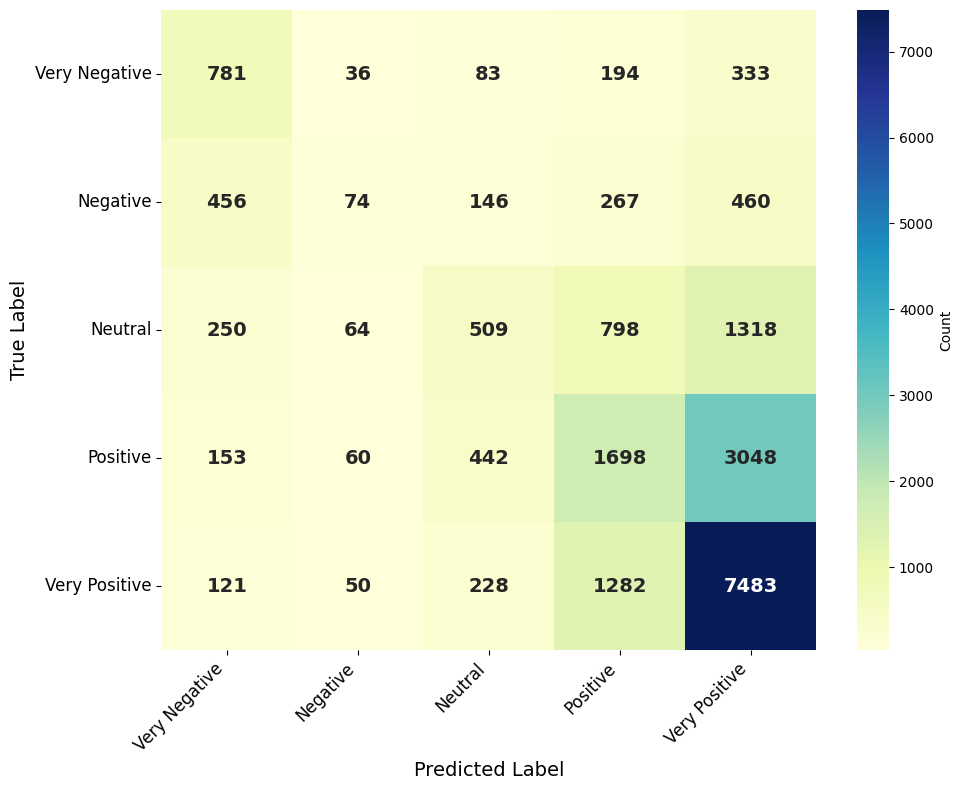

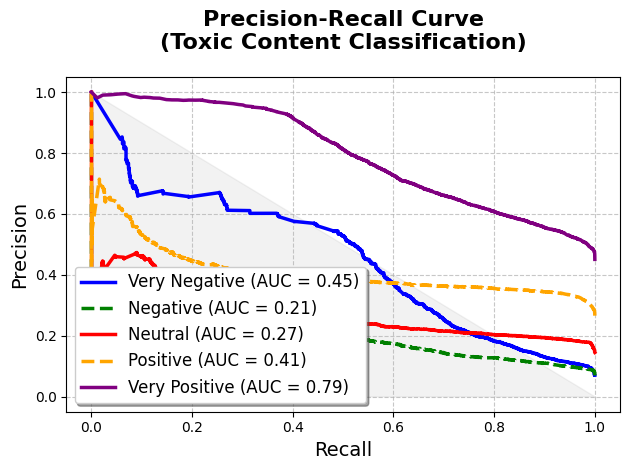

In [20]:
test_model_UCB(model,os.path.join(model_dir, "training_metrics_sentiment_Post.png"))

In [ ]:
# Define Multi-Task Model

                   ┌────────────────────────┐
                   │    BERT Encoder         │  ← shared across all tasks
                   └────────┬───────────────┘
                            │
          ┌────────────────┼────────────────────┐
          ▼                ▼                    ▼
  Sentiment Head     Toxicity Head        Respect Head
 (3 classes)         (binary)             (binary)
         ...


Before Fine-tuning:


/home/mabon/anaconda3/envs/torch2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mabon/anaconda3/envs/torch2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mabon/anaconda3/envs/torch2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

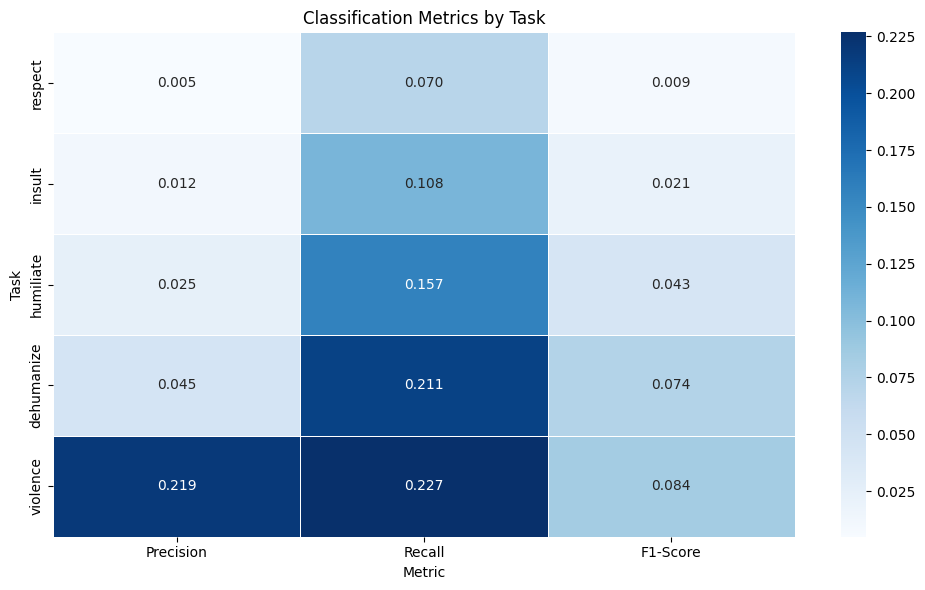

In [8]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class MultiTaskBERT(nn.Module):
    def __init__(self, model_name, task_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.classifiers = nn.ModuleDict({
            task: nn.Linear(hidden_size, num_labels)
            for task, num_labels in task_labels.items()
        })
    
    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = outputs.pooler_output
        return {
            task: classifier(pooled_output)
            for task, classifier in self.classifiers.items()
        }

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

class MultiTaskDataset(Dataset):
    def __init__(self, df, tokenizer, task_labels, max_length=128):
        self.sentences = df["sentence"].tolist()
        self.labels = df
        self.tokenizer = tokenizer
        self.task_labels = task_labels
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        encoded = self.tokenizer(sentence, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        inputs = {k: v.squeeze() for k, v in encoded.items()}

        # Multitask labels
        for task in self.task_labels:
            label = int(self.labels.iloc[idx][task])
            inputs[f"label_{task}"] = torch.tensor(label)
        return inputs
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if not k.startswith("label_")}
        labels = {k[len("label_"):]: v.to(device) for k, v in batch.items() if k.startswith("label_")}

        outputs = model(**inputs)
        loss = 0
        for task in outputs:
            loss += loss_fn(outputs[task], labels[task])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

import seaborn as sns
from sklearn.metrics import classification_report

def evaluate(model, dataloader, device, task_labels):
    model.eval()
    
    # Initialize dictionaries for storing predictions and ground truths for each task
    predictions = {task: [] for task in task_labels}
    ground_truth = {task: [] for task in task_labels}
    
    with torch.no_grad():
        for batch in dataloader:
            # Move input data to device
            inputs = {k: v.to(device) for k, v in batch.items() if not k.startswith("label_")}
            # Extract labels
            labels = {k[len("label_"):]: v for k, v in batch.items() if k.startswith("label_")}
            # Model inference
            outputs = model(**inputs)

            for task in task_labels:
                pred = torch.argmax(outputs[task], dim=1).cpu().numpy()
                true = labels[task].numpy()
                predictions[task].extend(pred)
                ground_truth[task].extend(true)

    # Create dictionaries to store classification report metrics
    metrics = {task: classification_report(ground_truth[task], predictions[task], output_dict=True) for task in task_labels}

    # Prepare data for the matrix (precision, recall, f1-score for each task)
    rows = []
    columns = ['Precision', 'Recall', 'F1-Score']
    
    for task in task_labels:
        rows.append([metrics[task]['weighted avg']['precision'], 
                     metrics[task]['weighted avg']['recall'], 
                     metrics[task]['weighted avg']['f1-score']])

    # Create a DataFrame for easier plotting
    metrics_df = pd.DataFrame(rows, columns=columns, index=task_labels)

    # Plotting the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(metrics_df, annot=True, cmap='Blues', fmt='.3f', cbar=True, linewidths=0.5)
    
    plt.title('Classification Metrics by Task')
    plt.xlabel('Metric')
    plt.ylabel('Task')
    plt.tight_layout()
    plt.show()

        
model_name = "bert-base-uncased"
task_labels = {
    "respect": 2,
    "insult": 2,
    "humiliate": 2,
    "dehumanize": 2,
    "violence": 2
}

tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df, test_df = train_test_split(data, test_size=0.2, stratify=data["label"])
train_df_small, _ = train_test_split(train_df, train_size=0.2, stratify=train_df["label"])  # small subset

train_ds = MultiTaskDataset(train_df_small, tokenizer, task_labels)
test_ds = MultiTaskDataset(test_df, tokenizer, task_labels)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

model = MultiTaskBERT(model_name, task_labels).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# 🔍 Evaluate pre-finetuning
print("Before Fine-tuning:")
evaluate(model, test_loader, device, task_labels)
